Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

First reload the data we generated in _notmist.ipynb_.

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


### Helper methods

In [41]:
def plot_loss(x, y):
  plt.figure(figsize=(16, 4))
  plt.plot(x, y)
  plt.xlabel("Step")
  plt.ylabel("Loss")

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def create_batch(step):
  # Pick an offset within the training data, which has been randomized.
  # Note: we could use better randomization across epochs.
  offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

  # Generate a minibatch.
  batch_data = train_dataset[offset:(offset + batch_size), :]
  batch_labels = train_labels[offset:(offset + batch_size), :]
  return [batch_data, batch_labels]

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

### Logistic model + L2 Regularization

#### Stotachistic Gradient Descent

In [6]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Apply regularization
  loss += 5e-4 * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [7]:
def do_tf_train(batch_size, num_steps):
  xx = []
  yy = []
  with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
      # Pick an offset within the training data, which has been randomized.
      # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

      # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]

      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}

      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)

      if (step % 20 == 0):
          xx.append(step)
          yy.append(l)

      if (step % 500 == 0):
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    plot_loss(xx, yy)

Initialized
Minibatch loss at step 0: 15.693619
Minibatch accuracy: 13.3%
Validation accuracy: 15.9%
Minibatch loss at step 500: 2.045900
Minibatch accuracy: 77.3%
Validation accuracy: 75.9%
Minibatch loss at step 1000: 1.701473
Minibatch accuracy: 79.7%
Validation accuracy: 77.4%
Minibatch loss at step 1500: 1.111607
Minibatch accuracy: 78.1%
Validation accuracy: 78.7%
Minibatch loss at step 2000: 1.029701
Minibatch accuracy: 82.0%
Validation accuracy: 79.3%
Minibatch loss at step 2500: 0.912838
Minibatch accuracy: 81.2%
Validation accuracy: 80.4%
Minibatch loss at step 3000: 0.954550
Minibatch accuracy: 81.2%
Validation accuracy: 80.4%
Test accuracy: 88.0%


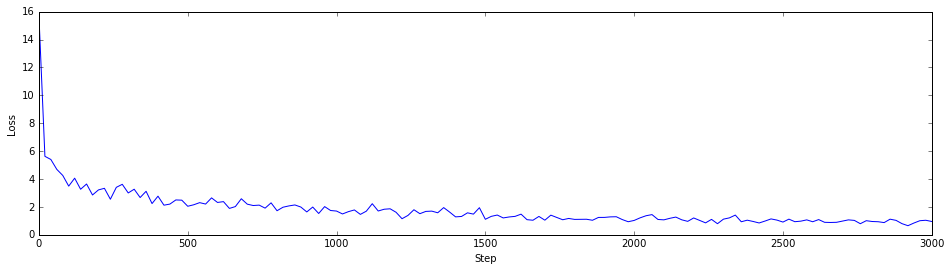

In [8]:
do_tf_train(128, 3001)

### Neural Network + L2 Regularization

In [9]:
batch_size = 128
hidden_units = 1024 # Size of the hidden layer


graph = tf.Graph()
with graph.as_default() as g:
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Hidden Layer
  with g.name_scope("hidden"):
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_units]),
        name='weights1')
    biases1 = tf.Variable(tf.zeros([hidden_units]), name='biases')
  
  # Linear
  with g.name_scope("softmax_linear"):
    weights2 = tf.Variable(
        tf.truncated_normal([hidden_units, num_labels]),
        name='weights2')
    biases2 = tf.Variable(tf.zeros([num_labels]), name='biases')
  
  def forward_prop(inp):
    return tf.matmul(
        tf.nn.relu(tf.matmul(inp, weights1) + biases1), weights2) + biases2  

  logits = forward_prop(tf_train_dataset)

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

  # Apply regularization
  loss += 5e-4 * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)


  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
  test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

Initialized
Minibatch loss at step 0: 476.904602
Minibatch accuracy: 7.0%
Validation accuracy: 27.4%
Minibatch loss at step 500: 141.024780
Minibatch accuracy: 73.4%
Validation accuracy: 79.7%
Minibatch loss at step 1000: 96.381271
Minibatch accuracy: 82.8%
Validation accuracy: 82.0%
Minibatch loss at step 1500: 74.096481
Minibatch accuracy: 84.4%
Validation accuracy: 81.9%
Minibatch loss at step 2000: 56.622368
Minibatch accuracy: 86.7%
Validation accuracy: 82.2%
Minibatch loss at step 2500: 43.663784
Minibatch accuracy: 87.5%
Validation accuracy: 83.2%
Minibatch loss at step 3000: 34.005566
Minibatch accuracy: 85.2%
Validation accuracy: 85.0%
Test accuracy: 91.2%


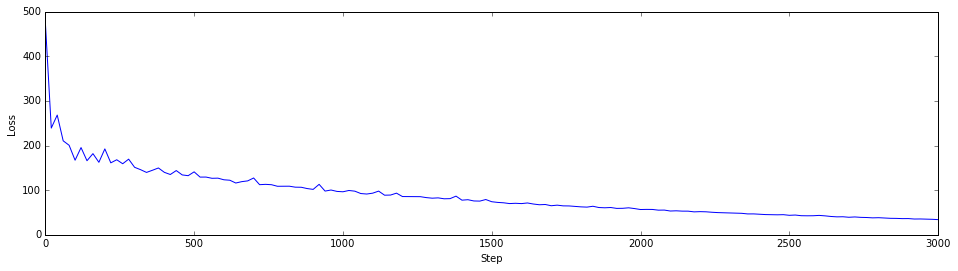

In [10]:
do_tf_train(128, 3001)

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [24]:
batch_size = 20
hidden_units = 1024 # Size of the hidden layer

graph = tf.Graph()
with graph.as_default() as g:
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Hidden Layer
  with g.name_scope("hidden"):
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_units]),
        name='weights1')
    biases1 = tf.Variable(tf.zeros([hidden_units]), name='biases')
  
  # Linear
  with g.name_scope("softmax_linear"):
    weights2 = tf.Variable(
        tf.truncated_normal([hidden_units, num_labels]),
        name='weights2')
    biases2 = tf.Variable(tf.zeros([num_labels]), name='biases')
  
  def forward_prop(inp):
    return tf.matmul(
        tf.nn.relu(tf.matmul(inp, weights1) + biases1), weights2) + biases2  

  logits = forward_prop(tf_train_dataset)

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

  # Apply regularization
  loss += 5e-4 * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)


  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
  test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

Initialized
Minibatch loss at step 0: 548.028687
Minibatch accuracy: 0.0%
Validation accuracy: 15.4%
Minibatch loss at step 500: 245.861389
Minibatch accuracy: 65.0%
Validation accuracy: 65.3%
Minibatch loss at step 1000: 233.172684
Minibatch accuracy: 60.0%
Validation accuracy: 61.0%
Minibatch loss at step 1500: 82.377968
Minibatch accuracy: 65.0%
Validation accuracy: 67.2%
Minibatch loss at step 2000: 62.648827
Minibatch accuracy: 65.0%
Validation accuracy: 73.1%
Minibatch loss at step 2500: 47.771305
Minibatch accuracy: 85.0%
Validation accuracy: 76.9%
Minibatch loss at step 3000: 37.344307
Minibatch accuracy: 75.0%
Validation accuracy: 78.2%
Test accuracy: 85.1%


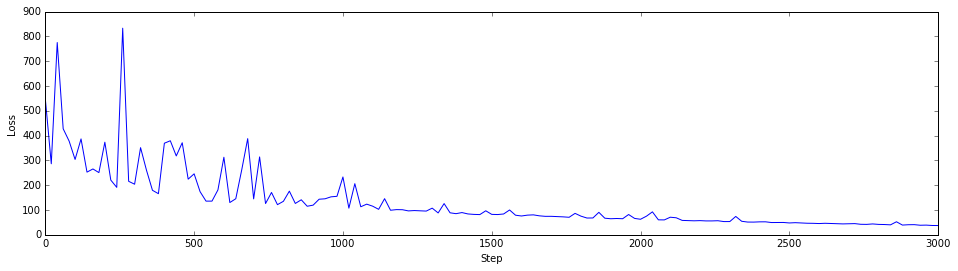

In [25]:
do_tf_train(batch_size, 3001)

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

---

#### What does dropout function do?

```
In [1]: import tensorflow as tf
In [2]: sess = tf.InteractiveSession()

In [8]:  a = tf.constant([1.0, 3.0, 2.0, 4.0, 8.0, 1.0, 2.0])

In [9]: a.eval()
Out[9]: array([ 1.,  3.,  2.,  4.,  8.,  1.,  2.], dtype=float32)

In [10]: b = tf.nn.dropout(a, 0.5)

In [11]: b.eval()
Out[11]: array([ 0.,  0.,  0.,  0.,  0.,  2.,  0.], dtype=float32)

In [12]: b.eval()
Out[12]: array([  0.,   0.,   4.,   0.,  16.,   0.,   0.], dtype=float32)

In [13]: b.eval()
Out[13]: array([  0.,   0.,   4.,   0.,  16.,   2.,   4.], dtype=float32)

In [14]: b.eval()
Out[14]: array([  2.,   0.,   4.,   8.,  16.,   0.,   4.], dtype=float32)

In [15]: b.eval()
Out[15]: array([ 2.,  0.,  0.,  0.,  0.,  0.,  4.], dtype=float32)

```

> Since the keep_probability of 0.5 was used, array elements were dropped with that probability, and remaining elements were scaled up by 1/0.5 = 2

1. We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.

In [46]:
batch_size = 128
hidden_units = 1024 # Size of the hidden layer

graph = tf.Graph()
with graph.as_default() as g:
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Hidden Layer
  with g.name_scope("hidden"):
    weights1 = weight_variable([image_size * image_size, hidden_units])
    biases1 = bias_variable([hidden_units])
  
  # Linear
  with g.name_scope("softmax_linear"):
    weights2 = weight_variable([hidden_units, num_labels])
    biases2 = bias_variable([num_labels])
  
  def forward_prop(inp):
    return tf.matmul(
        tf.nn.relu(tf.matmul(inp, weights1) + biases1), weights2) + biases2  

  logits = forward_prop(tf_train_dataset)
  
  # Dropout
  logits_drop = tf.nn.dropout(logits, 0.5)

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits_drop, tf_train_labels))

  # Apply regularization
  loss += 5e-4 * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
  # Optimizer.
  optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_drop)
  valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
  test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

Initialized
Minibatch loss at step 0: 7.628120
Minibatch accuracy: 9.4%
Validation accuracy: 12.3%
Minibatch loss at step 500: 2.951389
Minibatch accuracy: 48.4%
Validation accuracy: 80.5%
Minibatch loss at step 1000: 2.886546
Minibatch accuracy: 49.2%
Validation accuracy: 82.5%
Minibatch loss at step 1500: 2.699205
Minibatch accuracy: 46.1%
Validation accuracy: 83.7%
Minibatch loss at step 2000: 2.519528
Minibatch accuracy: 52.3%
Validation accuracy: 84.7%
Minibatch loss at step 2500: 2.584833
Minibatch accuracy: 45.3%
Validation accuracy: 84.9%
Minibatch loss at step 3000: 2.586389
Minibatch accuracy: 47.7%
Validation accuracy: 85.3%
Test accuracy: 91.9%


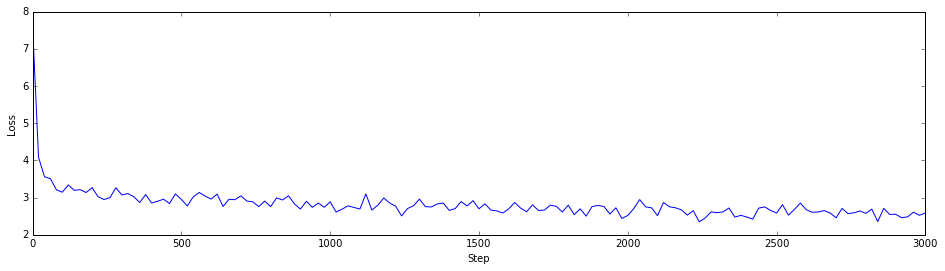

In [47]:
do_tf_train(batch_size, 3001)

What happens to our extreme overfitting case?

---

In [48]:
batch_size = 20
hidden_units = 1024 # Size of the hidden layer

graph = tf.Graph()
with graph.as_default() as g:
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Hidden Layer
  with g.name_scope("hidden"):
    weights1 = weight_variable([image_size * image_size, hidden_units])
    biases1 = bias_variable([hidden_units])
  
  # Linear
  with g.name_scope("softmax_linear"):
    weights2 = weight_variable([hidden_units, num_labels])
    biases2 = bias_variable([num_labels])
  
  def forward_prop(inp):
    return tf.matmul(
        tf.nn.relu(tf.matmul(inp, weights1) + biases1), weights2) + biases2  

  logits = forward_prop(tf_train_dataset)
  
  # Dropout
  logits_drop = tf.nn.dropout(logits, 0.5)

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits_drop, tf_train_labels))

  # Apply regularization
  loss += 5e-4 * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
  # Optimizer.
  optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_drop)
  valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
  test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

Initialized
Minibatch loss at step 0: 7.809378
Minibatch accuracy: 10.0%
Validation accuracy: 4.6%
Minibatch loss at step 500: 3.851542
Minibatch accuracy: 30.0%
Validation accuracy: 76.8%
Minibatch loss at step 1000: 3.167903
Minibatch accuracy: 30.0%
Validation accuracy: 78.7%
Minibatch loss at step 1500: 2.877496
Minibatch accuracy: 40.0%
Validation accuracy: 80.6%
Minibatch loss at step 2000: 2.869808
Minibatch accuracy: 40.0%
Validation accuracy: 81.4%
Minibatch loss at step 2500: 2.950448
Minibatch accuracy: 50.0%
Validation accuracy: 82.3%
Minibatch loss at step 3000: 2.580415
Minibatch accuracy: 55.0%
Validation accuracy: 81.8%
Test accuracy: 88.9%


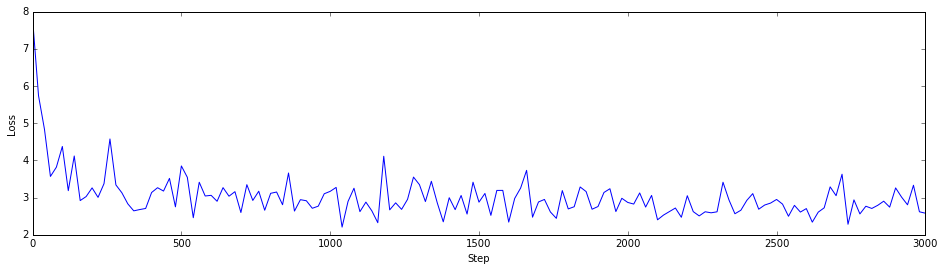

In [49]:
do_tf_train(batch_size, 3001)

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


### 4 Layer network

In [52]:
batch_size = 128
hidden_units_1 = 1024 # Size of the hidden layer
hidden_units_2 = 300
hidden_units_3 = 50

graph = tf.Graph()
with graph.as_default() as g:
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Hidden Layer 1
  with g.name_scope("hidden1"):
    weights1 = weight_variable([image_size * image_size, hidden_units_1])
    biases1 = bias_variable([hidden_units_1])

  with g.name_scope("hidden2"):
    weights2 = weight_variable([hidden_units_1, hidden_units_2])
    biases2 = bias_variable([hidden_units_2])
    
  with g.name_scope("hidden3"):
    weights3 = weight_variable([hidden_units_2, hidden_units_3])
    biases3 = bias_variable([hidden_units_3])
  
  # Linear
  with g.name_scope("softmax_linear"):
    weights4 = weight_variable([hidden_units_3, num_labels])
    biases4 = bias_variable([num_labels])
  
  def forward_prop(inp):
    initial = tf.matmul(inp, weights1 ) + biases1
    initial = tf.matmul(tf.nn.relu(initial), weights2) + biases2
    initial = tf.matmul(tf.nn.relu(initial), weights3) + biases3
    initial = tf.matmul(tf.nn.relu(initial), weights4) + biases4
    return initial  

  logits = forward_prop(tf_train_dataset)
  
  # Dropout
  logits_drop = tf.nn.dropout(logits, 0.5)

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits_drop, tf_train_labels))

  # Apply regularization
  loss += 5e-4 * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
  # Optimizer.
  optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_drop)
  valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
  test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

Initialized
Minibatch loss at step 0: 5.472296
Minibatch accuracy: 9.4%
Validation accuracy: 7.5%
Minibatch loss at step 500: 3.120972
Minibatch accuracy: 53.1%
Validation accuracy: 82.6%
Minibatch loss at step 1000: 3.212160
Minibatch accuracy: 45.3%
Validation accuracy: 84.0%
Minibatch loss at step 1500: 2.951932
Minibatch accuracy: 52.3%
Validation accuracy: 85.1%
Minibatch loss at step 2000: 2.714409
Minibatch accuracy: 54.7%
Validation accuracy: 85.7%
Minibatch loss at step 2500: 2.789465
Minibatch accuracy: 52.3%
Validation accuracy: 86.3%
Minibatch loss at step 3000: 2.710142
Minibatch accuracy: 49.2%
Validation accuracy: 86.5%
Test accuracy: 93.0%


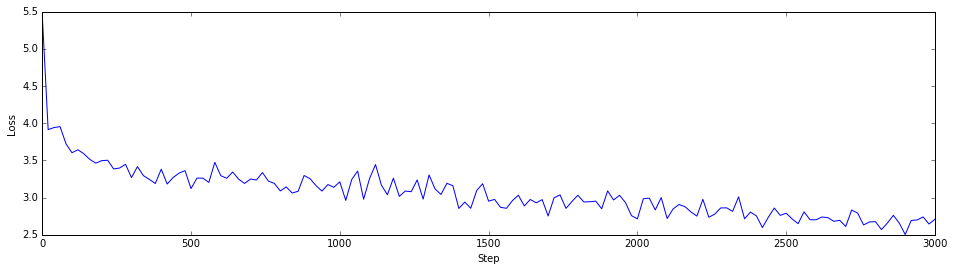

In [51]:
do_tf_train(batch_size, num_steps)

### 4 Layer network + Learning rate decay

In [61]:
batch_size = 128
hidden_units_1 = 1024 # Size of the hidden layer
hidden_units_2 = 300
hidden_units_3 = 50

graph = tf.Graph()
with graph.as_default() as g:
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Hidden Layer 1
  with g.name_scope("hidden1"):
    weights1 = weight_variable([image_size * image_size, hidden_units_1])
    biases1 = bias_variable([hidden_units_1])

  with g.name_scope("hidden2"):
    weights2 = weight_variable([hidden_units_1, hidden_units_2])
    biases2 = bias_variable([hidden_units_2])
    
  with g.name_scope("hidden3"):
    weights3 = weight_variable([hidden_units_2, hidden_units_3])
    biases3 = bias_variable([hidden_units_3])
  
  # Linear
  with g.name_scope("softmax_linear"):
    weights4 = weight_variable([hidden_units_3, num_labels])
    biases4 = bias_variable([num_labels])
  
  def forward_prop(inp):
    initial = tf.matmul(inp, weights1 ) + biases1
    initial = tf.matmul(tf.nn.relu(initial), weights2) + biases2
    initial = tf.matmul(tf.nn.relu(initial), weights3) + biases3
    initial = tf.matmul(tf.nn.relu(initial), weights4) + biases4
    return initial  

  logits = forward_prop(tf_train_dataset)
  
  # Dropout
  logits_drop = tf.nn.dropout(logits, 0.5)

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits_drop, tf_train_labels))

  # Apply regularization
  loss += 5e-4 * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
  # Learning rate decay
  global_step = tf.Variable(0, name="global_step", trainable=False)
  learning_rate = tf.train.exponential_decay(0.1,
                                             global_step,
                                             100000,
                                             0.96,
                                             staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_drop)
  valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
  test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

Initialized
Minibatch loss at step 0: 6.378026
Minibatch accuracy: 12.5%
Validation accuracy: 11.4%
Minibatch loss at step 500: 3.187098
Minibatch accuracy: 56.2%
Validation accuracy: 83.3%
Minibatch loss at step 1000: 3.128890
Minibatch accuracy: 50.8%
Validation accuracy: 84.3%
Minibatch loss at step 1500: 2.983993
Minibatch accuracy: 55.5%
Validation accuracy: 85.0%
Minibatch loss at step 2000: 2.924783
Minibatch accuracy: 44.5%
Validation accuracy: 85.5%
Minibatch loss at step 2500: 2.919226
Minibatch accuracy: 45.3%
Validation accuracy: 86.3%
Minibatch loss at step 3000: 2.902477
Minibatch accuracy: 41.4%
Validation accuracy: 86.2%
Test accuracy: 93.0%


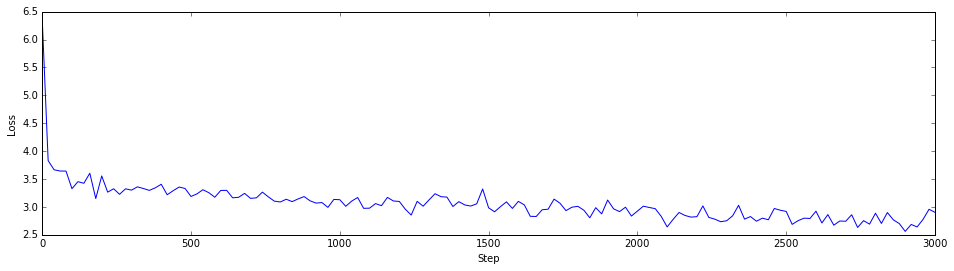

In [62]:
xx = []
yy = []
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]

    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data,
                 tf_train_labels : batch_labels}

    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)

    if (step % 20 == 0):
        xx.append(step)
        yy.append(l)

    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  plot_loss(xx, yy)